# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [22]:
import sys
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# df = pd.read_csv('drive/MyDrive/colab_notebooks/datasets/data.txt.zip', header=None)
df = pd.read_csv('../input/hse-hw-1/YearPredictionMSD.txt', header=None)
print(df.shape)
df.head()

(515345, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


<AxesSubplot:>

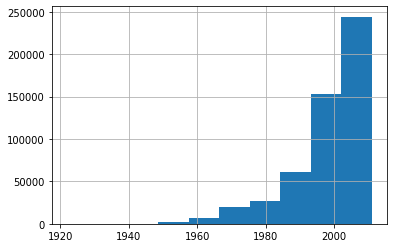

In [5]:
df[0].hist()

In [6]:
# фиксированное трейн/тест разделение
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [7]:
X_train.shape

(463715, 90)

In [8]:
X_test.shape

(51630, 90)

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. 

Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

### Ridge Regression

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

best_train_constant = sum(y_train)/len(y_train)

model = Ridge()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


print(
    f'RMSE on train = {mean_squared_error(y_train, y_pred_train, squared=False)}',
    f'RMSE on test = {mean_squared_error(y_test, y_pred_test, squared=False)}',
    f'RMSE on best constant = {mean_squared_error(y_test, best_train_constant * np.ones(y_test.shape))}',
    sep='\n'
)

# Оптимальное решение в задаче минимизации MSE и RMSE в классе констант – среднее арифметическое

RMSE on train = 9.552822967904056
RMSE on test = 9.510160711373397
RMSE on best constant = 117.77597281228708


### CatBoostRegressor

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [11]:
set_random_seed(77)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [12]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]

In [13]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
       
        # self.batch_norm = torch.nn.BatchNorm1d(90)
        
        self.linear1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=90, out_features=1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1000),
            torch.nn.Dropout(0.2)
        )     
        self.linear2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=1000, out_features=2500),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(2500),
            torch.nn.Dropout(0.2)
        )
        # self.linear3 = torch.nn.Sequential(
        #     torch.nn.Linear(in_features=2500, out_features=500),
        #     torch.nn.ReLU(),
        #     torch.nn.BatchNorm1d(500),
        #     torch.nn.Dropout(0.2)
        # )
        self.output = torch.nn.Linear(in_features=2500, out_features=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        # x = self.linear3(x)
        
        return self.output(x)

In [14]:
def plot_history(train_history, val_history, title="loss"):
    """
    Функция построения графика обучения эпохи.
    - train_history - набор лоссов по всем батчам на всех эпохах
    - val_history - набор средних лоссов по батчам на всех эпохах
    """    
    # подбираем шаг для средних значений val_loss
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.title(title)
    plt.xlabel("train steps")
    plt.grid()
    
    plt.plot(train_history, label="train", zorder=1)
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    
    plt.legend(loc="best")
    plt.show()

In [15]:
def train_model(model, optimizer, criterion, train_loader, test_loader, n_epochs=5):
    '''
    Функция обучения выбранной модели
    
    Параметры:
        model - модель, унаследованная от torch.nn.Module 
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - тренировочный даталоадер из torch.utils.data.Dataloader 
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    
    # логи для трейн-лоссов и средних вал-лоссов по батчам по всем эпохам
    train_loss_total, val_mean_loss_total = [], []  
    
    for num_epoch, epoch in enumerate(range(n_epochs)):
        
        # обучение эпохи
        model.train()
        train_loss_epoch, val_loss_epoch = torch.empty(0), torch.empty(0)          # наборы логов по эпохе
        train_loss_epoch, val_loss_epoch = train_loss_epoch.to(device), val_loss_epoch.to(device)

        with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
            for num_batch, (x_batch, y_batch) in enumerate(train_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # шаг оптимизатора по одному батчу
                y_pred = model(x_batch).squeeze(1)
                loss = torch.sqrt(criterion(y_pred, y_batch.to(torch.float32)))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # логгируем loss
                train_loss_epoch = torch.cat((train_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе 
                train_loss_total.append(loss.item())                                  # общие лосс по батчам

                # tqdm вывод
                if num_batch%(len(train_loader)//200)==0:
                    pbar.set_description(f"Loss: {round(train_loss_epoch.mean().item(),3)} ") 
                pbar.update(1)

        # валидация
        model.eval()
        with tqdm(total=len(test_loader)) as pbar:
            with torch.no_grad():
                for num_batch, (x_batch, y_batch) in enumerate(test_loader):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # находим лосс по батчу
                    y_pred = model(x_batch).squeeze(1)
                    loss = torch.sqrt(criterion(y_pred, y_batch.to(torch.float32)))

                    # логируем loss
                    val_loss_epoch = torch.cat((val_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе

                    # tqdm вывод
                    if num_batch%(len(test_loader)//200)==0:
                        pbar.set_description(f"Loss: {round(val_loss_epoch.mean().item(),3)} ")                    
                    pbar.update(1)
                    
        val_mean_loss_total.append(val_loss_epoch.mean().item()) # общие лоссы по эпохам       
        
        # визуализация текущего процесса обучения
        clear_output()
        plot_history(train_loss_total, val_mean_loss_total)
        print(f"{'='*10} Epoch {num_epoch+1} {'='*10}\n")
        print("Train loss:", train_loss_epoch.mean().item())
        print("Val loss:", val_loss_epoch.mean().item())

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [18]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

In [19]:
# tmp = next(iter(train_loader))
# tmp[0].shape

In [24]:
model = MyModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters()) 
# criterion = F.mse_loss # отсюда еще нужно взять torch.sqrt() 
criterion = torch.nn.MSELoss(reduction='mean')

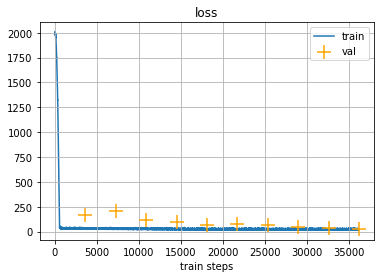

========== Epoch 10 ==========

Train loss: 22.74938201904297
Val loss: 29.715824127197266
CPU times: user 2min 13s, sys: 3.59 s, total: 2min 17s
Wall time: 2min 17s


In [25]:
%%time
train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=10
)

In [26]:
# предикт через sklearn
predictions = []
targets = []

for obj, target in tqdm(test_loader.dataset):
    predictions.append(model(obj.unsqueeze(0).to(device)).item())
    targets.append(target)

mean_squared_error(targets, predictions, squared=False)

100%|██████████| 51630/51630 [00:20<00:00, 2496.49it/s]


214.59708804276792

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ